## Decon using RedLionFish library

Works fine for small 3D arrays, but takes an extremely long time for large arrays

In [3]:
import reikna.cluda as cluda
api = cluda.ocl_api()
#code from test_reiknaFFT\reikna_getInfo.ipynb
devices = api.get_platforms()[0].get_devices()
print(f"OpenCL devices: {devices}")
for i in range(len(devices)):
    ocldevice = devices[i]
    print(f"Device {i}: {ocldevice}")
    print(f"max_work_group_size: {api.DeviceParameters(ocldevice).max_work_group_size}") # max_work_group_size: 1024
    print(f"max_work_item_sizes: {api.DeviceParameters(ocldevice).max_work_item_sizes}") # max_work_item_sizes: [1024, 1024, 64]
    print(f"max_num_groups: {api.DeviceParameters(ocldevice).max_num_groups}") # max_num_groups: [18446744073709551616, 18446744073709551616, 18446744073709551616]
    print(f"local_mem_size: {api.DeviceParameters(ocldevice).local_mem_size}") # local_mem_size: 49152
    print(f"local_mem_banks: {api.DeviceParameters(ocldevice).local_mem_banks}") # local_mem_banks: 32

OpenCL devices: [<pyopencl.Device 'NVIDIA GeForce RTX 3080' on 'NVIDIA CUDA' at 0x1e4a0d1aca0>]
Device 0: <pyopencl.Device 'NVIDIA GeForce RTX 3080' on 'NVIDIA CUDA' at 0x1e4a0d1aca0>
max_work_group_size: 1024
max_work_item_sizes: [1024, 1024, 64]
max_num_groups: [18446744073709551616, 18446744073709551616, 18446744073709551616]
local_mem_size: 49152
local_mem_banks: 32


In [4]:
import pyclesperanto_prototype as cle 
#Define a function for generating montages of the projection in different axes
def plot_montage_projections(img):
     
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,3, figsize=(10,5))

    ax[0].imshow(cle.maximum_x_projection(img))
    ax[0].set_title("Max X Projection")
    ax[1].imshow(cle.maximum_y_projection(img))
    ax[1].set_title("Max Y Projection")
    ax[2].imshow(cle.maximum_z_projection(img))
    ax[2].set_title("Max Z Projection")
    return


In [5]:
import RedLionfishDeconv as rl
from aicsimageio import AICSImage
from skimage.io import imread 
import numpy as np 
import logging
logging.basicConfig(level=logging.INFO)

psf_img = imread("../sample_data/psfs/zeiss_simulated/488.tif")

from napari_lattice.utils import crop_psf
psf_1 = crop_psf(psf_img,3e-3)

img = AICSImage("../sample_data/RBC_tiny.czi")
img.shape

img_data = np.squeeze(img.data)
print(f"Image shape is {img_data.shape}")

print(f"Orig PSF shape is {psf_img.shape}")
print(f"PSF shape is {psf_1.shape}")

Image shape is (834, 118, 209)
Orig PSF shape is (93, 205, 205)
PSF shape is (44, 86, 24)


In [33]:
%%timeit -r 1 -n 1
img_norm = rl.doRLDeconvolutionFromNpArrays(data_np = img_data, 
                                 psf_np = psf_1, 
                                 niter= 10, 
                                 method = "gpu")

2.02 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
#Get the data as timeit doesn't return data
img_norm_crop = rl.doRLDeconvolutionFromNpArrays(data_np = img_data, 
                                 psf_np = psf_1, 
                                 niter= 10, 
                                 method = "gpu")

In [8]:
#Get the data as timeit doesn't return data
img_normal = rl.doRLDeconvolutionFromNpArrays(data_np = img_data, 
                                 psf_np = psf_img, 
                                 niter= 10, 
                                 method = "gpu")

In [ ]:
import napari

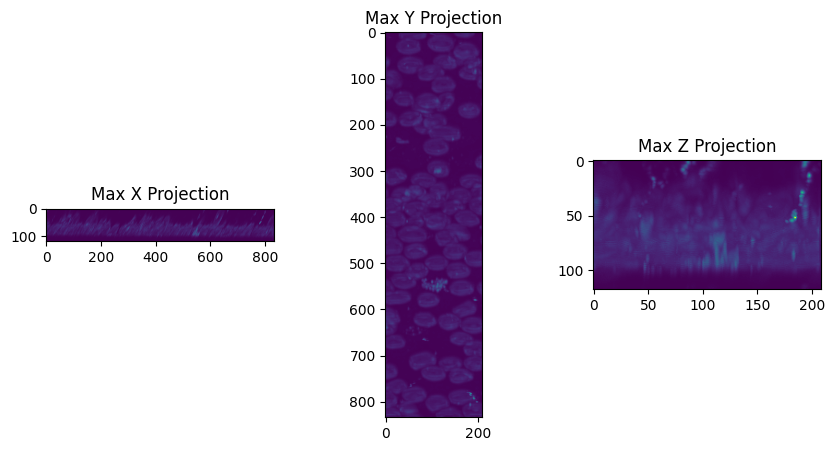

In [35]:
plot_montage_projections(img_norm)

In [6]:
from napari_lattice.utils import pad_image_nearest_multiple

img_data_pad = pad_image_nearest_multiple(img_data, 16)
img_data_pad.shape
psf_pad = pad_image_nearest_multiple(psf_1, 16)
psf_pad.shape

(48, 96, 32)

In [9]:
img_norm = rl.doRLDeconvolutionFromNpArrays(data_np = img_data_pad, 
                                 psf_np = psf_pad, 
                                 niter= 10, 
                                 method = "gpu")

In [10]:
img_norm = rl.doRLDeconvolutionFromNpArrays(data_np = img_data, 
                                 psf_np = psf_1, 
                                 niter= 10, 
                                 method = "gpu")

In [37]:
img_data.shape

(834, 118, 209)

WHat if we make image and psf dimensions even?

In [8]:
psf_pad = np.pad(psf_1,((0,1),(0,1),(0,1)))
img_data_pad = np.pad(img_data,((0,0),(0,0),(0,1)))

print(f"Padded image shape is {img_data_pad.shape}")


print(f"Padded PSF shape is {psf_pad.shape}")

Padded image shape is (834, 118, 210)
Padded PSF shape is (94, 206, 206)


In [9]:
%%timeit -r 1 -n 1
img_norm_pad = rl.doRLDeconvolutionFromNpArrays(data_np = img_data_pad, 
                                 psf_np = psf_pad, 
                                 niter= 10, 
                                 method = "gpu")

#Does take longer to run, but it could be because image is larger?

47.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


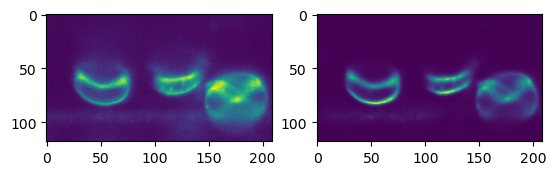

In [12]:
import matplotlib.pyplot as plt 

f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.squeeze(img.data)[40,...])
axarr[1].imshow(img_norm[40,...])


## Trying RL Decon option on a larger dataset. 

This can be downloaded from: https://cloudstor.aarnet.edu.au/plus/s/JerHyB7hAIOXiZw

In [11]:
import RedLionfishDeconv as rl
from aicsimageio import AICSImage
from skimage.io import imread 
import numpy as np 
import logging
logging.basicConfig(level=logging.INFO)

#Can also optionally generate a numpy array of shape (834,300,2048) for testing purposes
img_large = AICSImage("E:\Python_Repos\RBC_full_time_series.czi")
psf_img = imread("../sample_data/psfs/zeiss_simulated/488.tif")

from napari_lattice.utils import crop_psf
psf_1 = crop_psf(psf_img,3e-3)

img_large.dask_data

dask.array<transpose, shape=(3, 1, 834, 300, 2048), dtype=uint16, chunksize=(1, 1, 834, 300, 2048), chunktype=numpy.ndarray>

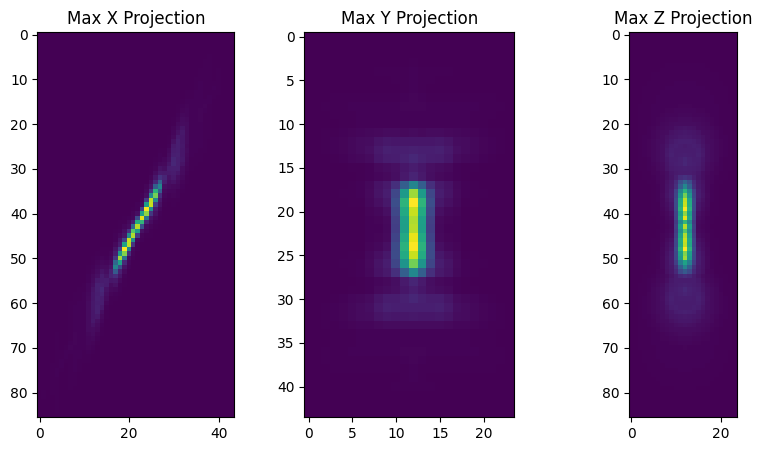

In [16]:
plot_montage_projections(psf_1)

In [12]:
img_large_data = img_large.data[0,0,...]
print(img_large_data.shape)

(834, 300, 2048)


In [1]:
#no padding

img_decon_large_no_pad= rl.doRLDeconvolutionFromNpArrays(data_np = img_large_data, 
                                                    psf_np = psf_1, 
                                                    niter= 10, 
                                                    method = "gpu")

NameError: name 'rl' is not defined

In [ ]:
img_decon_large_norm= rl.doRLDeconvolutionFromNpArrays(data_np = img_large_data, 
                                                    psf_np = psf_img, 
                                                    niter= 10, 
                                                    method = "gpu")

In [14]:
#psf padding
psf_pad = pad_image_nearest_multiple(psf_1,16)
img_large_data_pad = pad_image_nearest_multiple(img_large_data,16)

In [15]:

img_decon_large= rl.doRLDeconvolutionFromNpArrays(data_np = img_large_data_pad, 
                                                    psf_np = psf_pad, 
                                                    niter= 10, 
                                                    method = "gpu")

08-Nov-22 23:21:13 - root     - WARNING  - Adjusted blockshape is larger than GPU data size limits. Error may occur


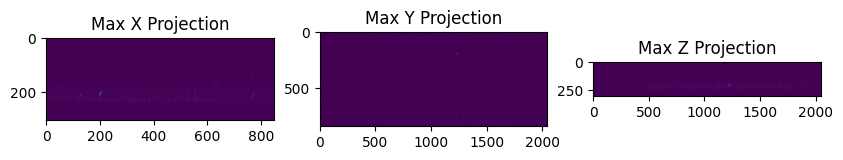

In [16]:
plot_montage_projections(img_decon_large)

In [19]:
import napari 
viewer = napari.Viewer()
viewer.add_image(img_large_data)
viewer.add_image(img_decon_large)

c:\Users\Pradeep\.conda\envs\napari_lattice\lib\site-packages\napari_tools_menu\__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img_decon_large' at 0x260de549550>

In [3]:
def pad_image_nearest_multiple(img:np.ndarray,nearest_multiple:int,is_psf=False):
    """pad an Image to the nearest multiple of provided number

    Args:
        img (np.ndarray): 
        nearest_multiple (int): Multiple of number to be padded

    Returns:
        np.ndarray: Padded image
    """    
    import math
    if is_psf:
        rounded_shape = (math.ceil(img.shape[0]/2)*2,
                         math.ceil(img.shape[1]/nearest_multiple)*nearest_multiple,
                         math.ceil(img.shape[2]/nearest_multiple)*nearest_multiple)
    else:
        rounded_shape = tuple([math.ceil(dim/nearest_multiple)*nearest_multiple for dim in img.shape])
    #get required padding
    
        
    padding = np.array(rounded_shape) - np.array(img.shape)
    padded_img = np.pad(img,((0,padding[0]),(0,padding[1]),(0,padding[2])),mode="reflect")
    return padded_img


#pad PSF by with multiple of 256
psf_pad = pad_image_nearest_multiple(psf_1,2,True)
img_pad = pad_image_nearest_multiple(img_large_data,2)

print(f"Padded image shape is {img_pad.shape}")
print(f"Padded PSF shape is {psf_pad.shape}")	

Padded image shape is (834, 300, 2048)
Padded PSF shape is (94, 206, 206)


Padding using even number dimensions for PSF and image was taking over 1 hour. Stopped execution

Padded image shape is (834, 300, 2048)
Padded PSF shape is (94, 206, 206) 

In [4]:
%%timeit -r 1 -n 1
img_decon_large= rl.doRLDeconvolutionFromNpArrays(data_np = img_pad, 
                                                    psf_np = psf_pad, 
                                                    niter= 10, 
                                                    method = "gpu")

KeyboardInterrupt: 

Padding PSF with multiple of 256. Image is padded to even numbers

In [4]:
#pad PSF by with multiple of 256
psf_pad = pad_image_nearest_multiple(psf_1,256,True)
img_pad = pad_image_nearest_multiple(img_large_data,2)

print(f"Padded image shape is {img_pad.shape}")
print(f"Padded PSF shape is {psf_pad.shape}")	

Padded image shape is (834, 300, 2048)
Padded PSF shape is (94, 256, 256)


Padding PSF to multiple of 256 and having image with even number dimensions, resulted in deconvolution taking only 1 m 19 s

In [8]:
%%timeit -r 1 -n 1
img_decon_large= rl.doRLDeconvolutionFromNpArrays(data_np = img_pad, 
                                                    psf_np = psf_pad, 
                                                    niter= 10, 
                                                    method = "gpu")

1min 19s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [5]:
%%timeit -r 1 -n 1
img_decon_large= rl.doRLDeconvolutionFromNpArrays(data_np = img_pad, 
                                                    psf_np = psf_pad, 
                                                    niter= 10, 
                                                    method = "gpu")
print(img_decon_large.shape)
print(img_pad.shape)

(834, 300, 2048)
(834, 300, 2048)


Padding image with multiples of 16 and PSF with 256



In [4]:
#pad PSF by with multiple of 256
psf_pad = pad_image_nearest_multiple(psf_1,256,True)
img_pad = pad_image_nearest_multiple(img_large_data,16)

print(f"Padded image shape is {img_pad.shape}")
print(f"Padded PSF shape is {psf_pad.shape}")

Padded image shape is (848, 304, 2048)
Padded PSF shape is (94, 256, 256)


In [5]:
%%timeit -r 1 -n 1
img_decon_large= rl.doRLDeconvolutionFromNpArrays(data_np = img_pad, 
                                                    psf_np = psf_pad, 
                                                    niter= 10, 
                                                    method = "gpu")

1min 27s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
img_decon_large= rl.doRLDeconvolutionFromNpArrays(data_np = img_pad, 
                                                    psf_np = psf_pad, 
                                                    niter= 10, 
                                                    method = "gpu")

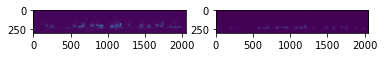

In [9]:
import matplotlib.pyplot as plt 
fig,axes = plt.subplots(1,2)

axes[0].imshow(img_large_data[40,...])
axes[1].imshow(img_decon_large[40,...])

#plt.imshow(img_decon_large[40,...])

In [10]:
import napari 

viewer = napari.Viewer()
viewer.add_image(img_large_data, name = "raw")
viewer.add_image(img_decon_large, name = "decon")

c:\Users\Pradeep\.conda\envs\napari_lattice\lib\site-packages\napari_tools_menu\__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'decon' at 0x1eab9f514c0>

### Tile overlap can be seen on the data plus there seems to be edge artefact with cells appearing on the top. Overlap doesn't seem to be accurate either

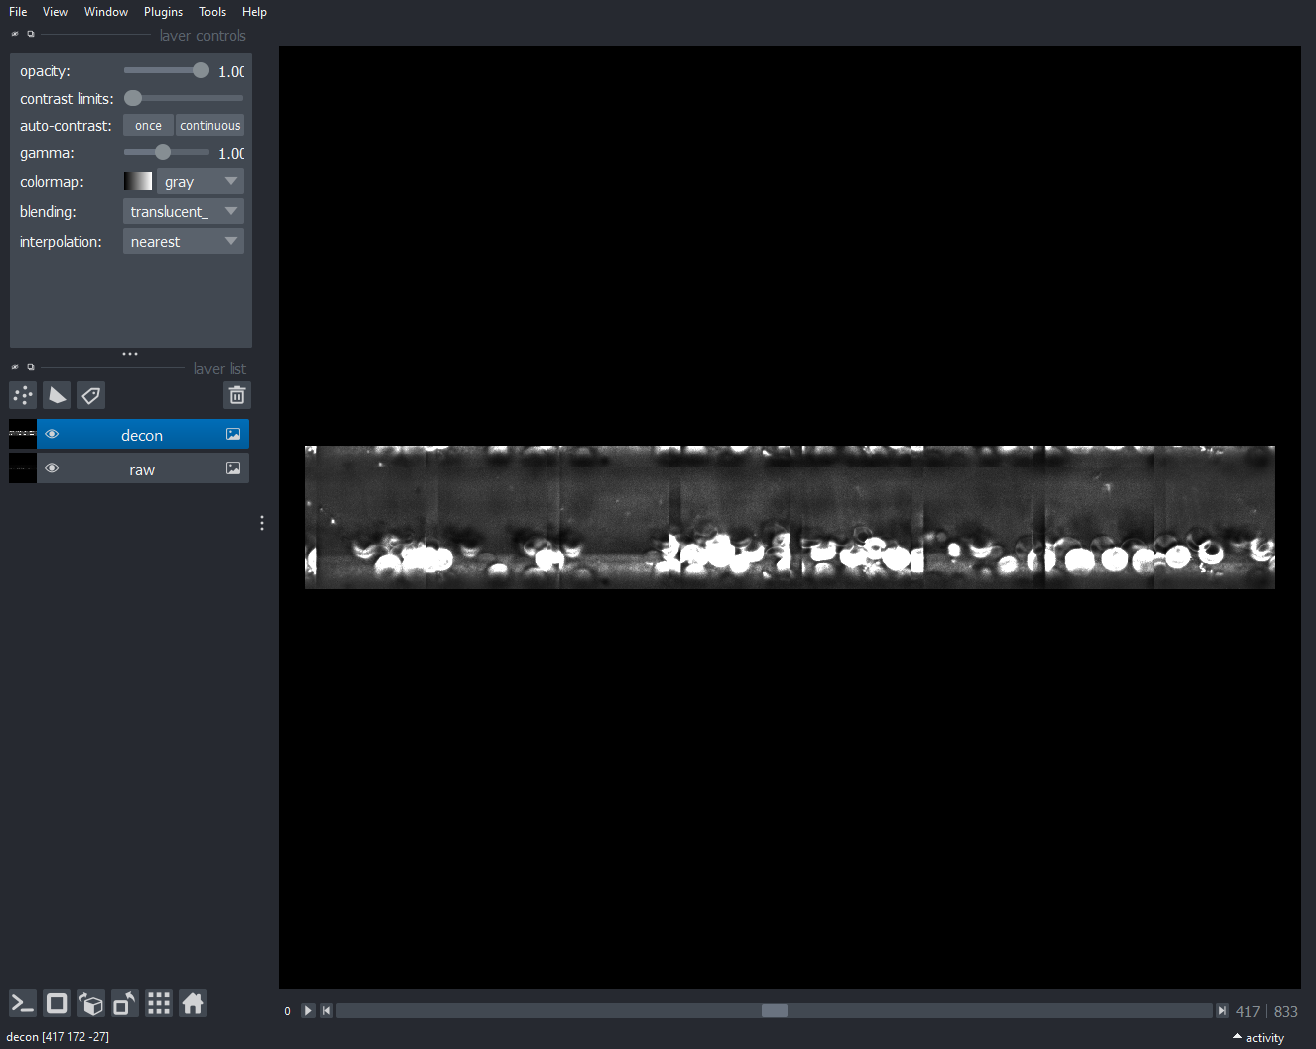

In [9]:
from napari.utils import nbscreenshot
nbscreenshot(viewer)

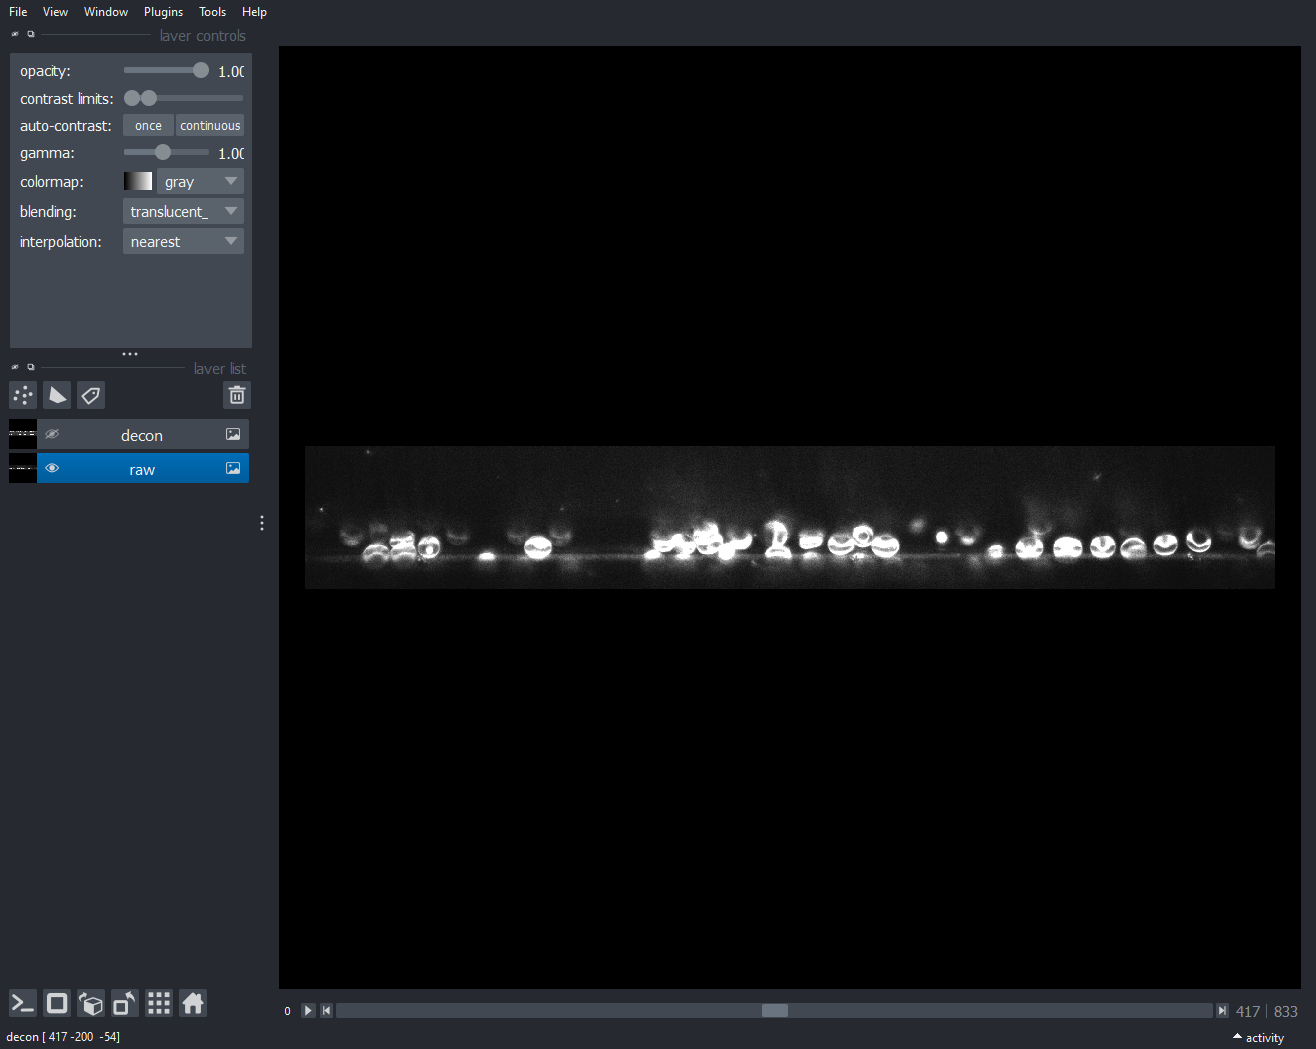

In [11]:
from napari.utils import nbscreenshot
nbscreenshot(viewer)